In [1]:
%load_ext autoreload
%autoreload 2

In [48]:
# Train the ML model
from utils import sample_files, encoder_files_to_tensors
from utils import plot_loss, load_encoder_data
from models import EncoderMulti, EncoderSingle

import time
import glob
import tensorflow as tf
from tensorflow import keras
import yaml
import os
import numpy as np
from datetime import datetime
import argparse
import matplotlib.pyplot as plt
import matplotlib as mpl



In [3]:
num_Turns_Case = 50+1
var_names = ['phEr', 'enEr', 'bl',
             'inten', 'Vrf', 'mu', 'VrfSPS']
# Initialize parameters
data_dir = '/eos/user/k/kiliakis/tomo_data/datasets'
# data_dir = './tomo_data/datasets'
timestamp = datetime.now().strftime("%Y_%m_%d_%H-%M-%S")
print('Using timestamp: ', timestamp)



Using timestamp:  2022_10_28_11-59-25


In [40]:
# Data specific
IMG_OUTPUT_SIZE = 128
BATCH_SIZE = 32  # 8

# Train specific
train_cfg = {
    'epochs': 10,
    'dense_layers': [64],
    'filters': [8, 16],
    'cropping': [0, 0],
    'kernel_size': 7,
    'strides': [2, 2],
    'activation': 'relu',
    'pooling': None,
    'pooling_size': [0, 0],
    'pooling_strides': [1, 1],
    'pooling_padding': 'valid',
    'dropout': 0.1,
    'loss': 'mse',
    'lr': 1e-3,
    'dataset%': 1,
    'normalization': 'minmax',
    'loss_weights': [0, 1, 2, 3, 4, 5, 6]

}

model_cfg = {
    'phEr': {
        'dropout': 0.,
        'filters': [8, 16, 32]
    }
}


In [5]:
# Initialize directories
trial_dir = os.path.join('./trials/', timestamp)
weights_dir = os.path.join(trial_dir, 'weights')
plots_dir = os.path.join(trial_dir, 'plots')

# Initialize train/ test / validation paths
ML_dir = os.path.join(data_dir, 'ML_data')
TRAINING_PATH = os.path.join(ML_dir, 'TRAINING')
VALIDATION_PATH = os.path.join(ML_dir, 'VALIDATION')
assert os.path.exists(TRAINING_PATH)
assert os.path.exists(VALIDATION_PATH)

# create the directory to store the results
os.makedirs(trial_dir, exist_ok=True)
os.makedirs(weights_dir, exist_ok=False)
os.makedirs(plots_dir, exist_ok=False)

# Initialize GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
device_to_use = 0

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        tf.config.experimental.set_memory_growth(gpus[device_to_use], True)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[device_to_use],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=12*1024)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(
            logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print('No GPU available, using the CPU')


No GPU available, using the CPU


2022-10-28 11:59:29.803821: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/lib:/usr/lib/x86_64-linux-gnu
2022-10-28 11:59:29.803838: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-28 11:59:29.803852: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sy153): /proc/driver/nvidia/version does not exist


In [41]:
start_t = time.time()
# Create the datasets
# 1. Randomly select the training data
file_names = sample_files(TRAINING_PATH, train_cfg['dataset%'], keep_every=num_Turns_Case)
print('Number of Training files: ', len(file_names))

x_train, y_train = encoder_files_to_tensors(
    file_names, normalization=train_cfg['normalization'])

# Repeat for validation data
file_names = sample_files(
    VALIDATION_PATH, train_cfg['dataset%'], keep_every=num_Turns_Case)
print('Number of Validation files: ', len(file_names))

x_valid, y_valid = encoder_files_to_tensors(
    file_names, normalization=train_cfg['normalization'])

end_t = time.time()
print(
    f'\n---- Input files have been read, elapsed: {end_t - start_t} ----\n')


Number of Training files:  6646
Number of Validation files:  1178

---- Input files have been read, elapsed: 507.4297275543213 ----



In [ ]:
start_t = time.time()
# Create the datasets
# 1. Randomly select the training data
file_names = sample_files(TRAINING_PATH, train_cfg['dataset%'], keep_every=num_Turns_Case)
print('Number of Training files: ', len(file_names))

# 2. Convert to tensor dataset
train_dataset = tf.data.Dataset.from_tensor_slices(file_names)

# 3. Then map function to dataset
# this returns pairs of tensors with shape (128, 128, 1) and (7,)
train_dataset = train_dataset.map(lambda x: tf.py_function(
    load_encoder_data,
    [x, train_cfg['normalization'], True],
    [tf.float32, tf.float32]))

# 4. Ignore errors in case they appear
train_dataset = train_dataset.apply(
    tf.data.experimental.ignore_errors())

# Repeat for validation data
file_names = sample_files(
    VALIDATION_PATH, train_cfg['dataset%'], keep_every=num_Turns_Case)
print('Number of Validation files: ', len(file_names))

# convert to dataset
valid_dataset = tf.data.Dataset.from_tensor_slices(file_names)
# Then map function to dataset
# this returns pairs of tensors with shape (128, 128, 1) and (7,)
valid_dataset = valid_dataset.map(lambda x: tf.py_function(
    load_encoder_data,
    [x, train_cfg['normalization'], True],
    [tf.float32, tf.float32]))
# Ignore errors
valid_dataset = valid_dataset.apply(
    tf.data.experimental.ignore_errors())

end_t = time.time()
print(
    f'\n---- Input files have been read, elapsed: {end_t - start_t} ----\n')

In [ ]:
%matplotlib inline
# plot some of the outputs

nrows = 3
# Get nrows * nrows random images
sample = np.random.choice(np.arange(len(x_train)),
                          size=nrows * nrows, replace=False)

samples_X = tf.gather(x_train, sample)
samples_y = tf.gather(y_train, sample)

# Create 3x3 grid of figures
fig, axes = plt.subplots(ncols=nrows, nrows=nrows, figsize=(12, 12))
axes = np.ravel(axes)
for i in range(len(axes)):
    ax = axes[i]
    ax.set_xticks([])
    ax.set_yticks([])
    # show the image
    ax.imshow(samples_X[i], cmap='jet')
    # Set the label
    title = ','.join([f'{num:.1f}' for num in samples_y[i]])
    ax.set_title(f'{title}')


In [51]:
# Model instantiation
input_shape = (IMG_OUTPUT_SIZE, IMG_OUTPUT_SIZE, 1)

train_cfg = {
    'epochs': 20,
    'dense_layers': [192],
    'filters': [8, 16, 32],
    'cropping': [7, 7],
    'kernel_size': 7,
    'strides': [2, 2],
    'activation': 'relu',
    'pooling': None,
    'pooling_size': [0, 0],
    'pooling_strides': [1, 1],
    'pooling_padding': 'valid',
    'dropout': 0.1,
    'loss': 'mse',
    'lr': 1e-3,
    'dataset%': 0.5,
    'normalization': 'minmax',
    'loss_weights': [0]
}

model_cfg = {
    'phEr': {
        'cropping': [7, 7],
        'dropout': 0.0,
        'filters': [8, 16, 32]
    }
}


output_names = np.array(var_names)[train_cfg['loss_weights']]
print(output_names)

models = {}
for i in train_cfg['loss_weights']:
    var_name = var_names[i]
    tmp_cfg = train_cfg.copy()
    tmp_cfg.update(model_cfg.get(var_name, {}))
    
    model = EncoderSingle(input_shape=input_shape,
                         output_name=var_name,
                         **tmp_cfg)

    models[var_name] = {'model': model.model,
                        'train': tf.gather(y_train, i, axis=1),
                        'valid': tf.gather(y_valid, i, axis=1)}
    print(models[var_name]['model'].summary())

# Train the encoder
historyMulti = {}

for var_name in models:
    model = models[var_name]['model']

    # Train the encoder
    print(f'\n---- {var_name}: Training the encoder ----\n')

    start_time = time.time()

    # callbacks, save the best model, and early stop if no improvement in val_loss
    stop_early = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               patience=5, restore_best_weights=True)
    save_best = keras.callbacks.ModelCheckpoint(filepath=os.path.join(weights_dir, f'encoder_{var_name}.h5'),
                                                monitor='val_loss', save_best_only=True)

    history = model.fit(
        x=x_train, y=models[var_name]['train'], epochs=train_cfg['epochs'],
        validation_data=(x_valid, models[var_name]['valid']),
        callbacks=[stop_early, save_best], batch_size=BATCH_SIZE,
        verbose=0)
    historyMulti[f'{var_name}_loss'] = history.history['loss']
    historyMulti[f'{var_name}_val_loss'] = history.history['val_loss']

    total_time = time.time() - start_time
    print(
        f'\n---- {var_name}: Training complete, epochs: {len(history.history["loss"])}, train loss {np.min(history.history["loss"]):.2e}, valid loss {np.min(history.history["val_loss"]):.2e}, total time {total_time} ----\n')


['phEr']
Model: "model_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 128, 128, 1)]     0         
                                                                 
 Crop (Cropping2D)           (None, 114, 114, 1)       0         
                                                                 
 phEr_CNN_1 (Conv2D)         (None, 54, 54, 8)         400       
                                                                 
 phEr_CNN_2 (Conv2D)         (None, 24, 24, 16)        6288      
                                                                 
 phEr_CNN_3 (Conv2D)         (None, 9, 9, 32)          25120     
                                                                 
 phEr_Flatten (Flatten)      (None, 2592)              0         
                                                                 
 phEr_Dense_1 (Dense)        (None, 192)         

In [ ]:
# Model instantiation
input_shape = (IMG_OUTPUT_SIZE, IMG_OUTPUT_SIZE, 1)
train_cfg['loss_weights'] = [0, 1, 2, 3, 4, 5, 6]

output_names = np.array(var_names)[train_cfg['loss_weights']]
print(output_names)

encoderMulti = EncoderMulti(input_shape=input_shape,
                            output_names=output_names, **train_cfg)
models = {}
for i in train_cfg['loss_weights']:
    var_name = var_names[i]
    models[var_name] = {'model': encoderMulti.models[var_name],
                        'train': train_dataset.map(lambda x, y: (x, y[i])).batch(1),
                        'valid': valid_dataset.map(lambda x, y: (x, y[i])).batch(1)}
    print(models[var_name]['model'].summary())

# Train the encoder
historyMulti = {}

for var_name in models:
    model = models[var_name]['model']

    # Train the encoder

    print(f'\n---- {var_name}: Training the encoder ----\n')

    start_time = time.time()

    # callbacks, save the best model, and early stop if no improvement in val_loss
    stop_early = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               patience=5, restore_best_weights=True)
    save_best = keras.callbacks.ModelCheckpoint(filepath=os.path.join(weights_dir, f'encoder_{var_name}.h5'),
                                                monitor='val_loss', save_best_only=True)

    history = model.fit(
        models[var_name]['train'], epochs=train_cfg['epochs'],
        validation_data=models[var_name]['valid'],
        callbacks=[stop_early, save_best],
        verbose=0)
    historyMulti[f'{var_name}_loss'] = history.history['loss']
    historyMulti[f'{var_name}_val_loss'] = history.history['val_loss']

    total_time = time.time() - start_time
    print(
        f'\n---- {var_name}: Training complete, epochs: {len(history.history["loss"])}, min loss {np.min(history.history["val_loss"])}, total time {total_time} ----\n')


[0.08635566 0.00130656 0.00099516 0.00087676 0.00090871 0.00079339
 0.00070996 0.00074452 0.00076117 0.00072223 0.00071142 0.00071698
 0.00064626 0.00066294 0.00067415 0.00060576 0.0006581  0.0005713
 0.00057793 0.00054924]
{'phEr_loss': [0.08635566383600235, 0.00130656105466187, 0.0009951636893674731, 0.0008767616818659008, 0.0009087055223062634, 0.0007933918386697769, 0.0007099639042280614, 0.0007445160881616175, 0.0007611724431626499, 0.0007222312269732356, 0.0007114195614121854, 0.0007169755990616977, 0.0006462613819167018, 0.00066293531563133, 0.0006741465185768902, 0.0006057590944692492, 0.0006580970366485417, 0.00057129783090204, 0.0005779281491413713, 0.0005492366035468876], 'phEr_val_loss': [0.000680627126712352, 0.00045627931831404567, 0.0010588299483060837, 0.000674256298225373, 0.0005089076003059745, 0.0004659492406062782, 0.00034062942722812295, 0.00013950112042948604, 0.00012012528168270364, 0.0005747910472564399, 0.0005539015401154757, 0.0003502069739624858, 0.0001098329

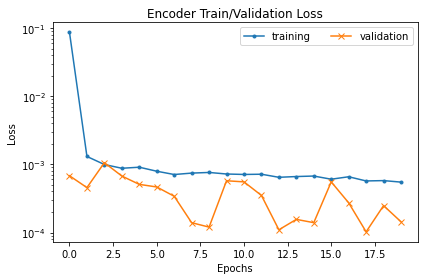

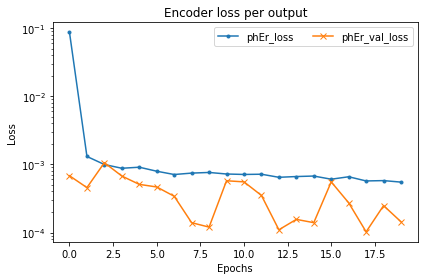

In [44]:
%matplotlib inline
train_loss_l = []
valid_loss_l = []
for k, v in historyMulti.items():
    if 'val' in k:
        valid_loss_l.append(v)
    else:
        train_loss_l.append(v)

train_loss_l = np.mean(train_loss_l, axis=0)
valid_loss_l = np.mean(valid_loss_l, axis=0)
print(train_loss_l)
plot_loss({'training': train_loss_l, 'validation': valid_loss_l},
            title='Encoder Train/Validation Loss')

plot_loss(historyMulti, title='Encoder loss per output')

print(historyMulti)

In [ ]:
from models import Encoder
# Model instantiation

input_shape = (IMG_OUTPUT_SIZE, IMG_OUTPUT_SIZE, 1)

encoder = Encoder(input_shape=input_shape, **train_cfg)

print(encoder.model.summary())

# Train the encoder

# callbacks, save the best model, and early stop if no improvement in val_loss
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=5, restore_best_weights=True)
save_best = keras.callbacks.ModelCheckpoint(filepath=os.path.join(weights_dir, 'encoder.h5'),
                                            monitor='val_loss', save_best_only=True)


start_time = time.time()
# history = encoder.model.fit(
#     train_dataset, epochs=train_cfg['epochs'],
#     validation_data=valid_dataset,
#     callbacks=[stop_early, save_best])
history = encoder.model.fit(
    x_train, y_train, epochs=train_cfg['epochs'],
    validation_data=(x_valid, y_valid),
    batch_size=BATCH_SIZE,
    callbacks=[stop_early, save_best])

total_time = time.time() - start_time


In [ ]:
print(history.history)

print(historyFunc.history)

In [ ]:
total = []
val_total = []
for k, v in history.history.items():
    if k != 'loss' and 'val' not in k:
        total.append(v)
    if k != 'val_loss' and 'val' in k:
        val_total.append(v)
    
total = np.array(total)
val_total = np.array(val_total)

weights = np.array(train_cfg['loss_weights']).reshape(-1, 1)
print('Mean:', np.sum(total*weights, axis=0)/np.sum(weights))
history.history['loss'] = np.sum(total*weights, axis=0)/np.sum(weights)
history.history['val_loss'] = np.sum(val_total*weights, axis=0)/np.sum(weights)


In [ ]:
%matplotlib widget
def plot_loss(lines, title='', figname=None):
    plt.figure()
    plt.title(title)
    for line in lines.keys():
        if 'val' in line:
            marker='x'
        else:
            marker='.'
        plt.semilogy(lines[line], marker=marker, label=line)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(ncol=2)
    plt.tight_layout()
    # if figname:
    #     plt.savefig(figname, dpi=300)
    # plt.close()

plot_loss(history.history)

train_loss_l = np.array(history.history['loss'])
valid_loss_l = np.array(history.history['val_loss'])

plot_loss({'Training': train_loss_l, 'Validation': valid_loss_l},
          title='Encoder Train/Validation Loss')


In [ ]:
from sklearn.metrics import mean_absolute_error

from functools import partial


def my_mse(y_true, y_pred):
    return tf.reduce_mean(tf.math.abs(y_pred - y_true), axis=0)


y_true = np.array([[0., 0.], [1., 1.]])
y_pred = np.array([[1., 0.5], [2., 1.5]])
loss = keras.losses.mean_absolute_error(y_true, y_pred)
mae2 = MyMeanAbsoluteError(reduction=keras.losses.Reduction.NONE)
mae = keras.losses.MeanAbsoluteError(reduction=keras.losses.Reduction.NONE)
lossv2 = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
# lossv3 = my_mse(1, y_true, y_pred)
# print(loss)
# print(mae(y_true, y_pred).numpy())
print(lossv2)
# print(mae2(y_true, y_pred).numpy())
# lossv4 = my_mse(y_true, y_pred)

print(my_mse(y_true, y_pred))
# print(my_mse(1, y_true, y_pred))


In [ ]:
# Plot training and validation loss
train_loss_l = np.array(history.history['loss'])
valid_loss_l = np.array(history.history['val_loss'])

plot_loss({'Training': train_loss_l, 'Validation': valid_loss_l},
          title='Encoder Train/Validation Loss',
          figname=os.path.join(plots_dir, 'encoder_train_valid_loss.png'))


In [ ]:
from sklearn.metrics import mean_squared_error

# get predictions
y_pred = encoder.model.predict(x_valid, verbose=False)
y_pred = np.array(y_pred)
y_valid = np.array(y_valid)

# Calculate error per variable
mses = mean_squared_error(y_valid, y_pred, multioutput='raw_values')

var_names = ['phase_error', 'energy_error',
             'bunch_length', 'intensity', 'Volt_rf', 'mu', 'Vrf_SPS']
# report
print('Variable\tMSE')
for name, mse in zip(var_names, mses):
    print(f'{name}:\t{mse:.4f}')


In [ ]:
from sklearn.metrics import mean_squared_error

# get predictions
y_pred = encoderFunc.model.predict(x_valid, verbose=False)
y_pred = np.array(y_pred).reshape(7, -1).T
y_valid = np.array(y_valid)
# Calculate error per variable
mses = mean_squared_error(y_valid, y_pred, multioutput='raw_values')
print(mses.shape)
var_names = ['phase_error', 'energy_error',
             'bunch_length', 'intensity', 'Volt_rf', 'mu', 'Vrf_SPS']
# report
print('Variable\tMSE')
for name, mse in zip(var_names, mses):
    print(f'{name}:\t{mse:.4f}')


In [ ]:
# save file with experiment configuration
config_dict = {}
config_dict['encoder'] = train_cfg.copy()
config_dict['encoder'].update({
    'min_train_loss': float(np.min(train_loss_l)),
    'min_valid_loss': float(np.min(valid_loss_l)),
    'total_train_time': total_time,
    'used_gpus': len(gpus)
})

# save config_dict
with open(os.path.join(trial_dir, 'encoder-summary.yml'), 'w') as configfile:
    yaml.dump(config_dict, configfile, default_flow_style=False)
